In [1]:
# default_exp fiducial_detect

# Import

In [2]:
# export
import copy
import math
import warnings

import torch
from skimage.measure import label, regionprops
from torchvision import transforms

from camera_calib.utils import *

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

from camera_calib.image import File16bitImg

# Dot vision checker board deep learning detector

This uses a neural net specifically trained on my dot vision checker board. Please look at :

https://github.com/justinblaber/fiducial_detect

For more info. torchscript is used so you don't have to define the model when you load it.

Note that `arr` needs to be a gray scale floating point image scaled between [0,1]

In [4]:
# export
class DotVisionCheckerDLDetector():
    def __init__(self, file_model, device=None):
        self.model = torch.jit.load(file_model.as_posix(), map_location=device).eval()

    def to(self, device):
        if device is None: return self
        self = copy.deepcopy(self)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            self.model.to(device)
        return self
 
    def format_arr(self, arr):
        if arr.min() < 0: warnings.warn('Value less than zero detected')
        if arr.max() > 1: warnings.warn('Value greater than 1 detected')
        
        arr = arr.float()                   # Must be single precision
        arr = imresize(arr, 384)            # Network trained on grayscale 384 sized images
        arr = rescale(arr, (0, 1), (-1, 1)) # Network trained on images between [-1,1]
        arr = arr[None, None]               # Add batch and channel dimension
        return arr
        
    def get_mask(self, arr):
        with torch.no_grad():
            mask = self.model(self.format_arr(arr)) # Inference
            mask = mask.argmax(dim=1)               # Convert from scores to labels
            mask = mask.squeeze(0)                  # Remove batch dimension
        return mask
        
    def __call__(self, arr):
        mask = self.get_mask(arr)

        # Extract fiducial points from mask
        ps_f = arr.new_full((4,2), math.nan)
        for idx, p_f in enumerate(ps_f):
            regions = regionprops(label(torch2np(mask) == (idx+1))) # regionprops doesnt work for gpu
            if len(regions) > 0:
                region = regions[arr.new_tensor([r.area for r in regions]).argmax()]
                ps_f[idx] = arr.new_tensor(reverse(region.centroid))
        ps_f *= (shape(arr)/shape(mask)).mean()

        return ps_f

Test it

In [5]:
file_model = Path('models/dot_vision_checker.pth')
file_img = Path('data/dot_vision_checker/SERIAL_16276942_DATETIME_2019-06-07-00:38:48-109736_CAM_3_FRAMEID_0_COUNTER_2.png')
detector = DotVisionCheckerDLDetector(file_model)
img = File16bitImg(file_img)
ps_f = detector(img.array_gs(torch.float))
ps_f

tensor([[ 979.1642,  517.3305],
        [ 156.6745,  498.4356],
        [ 973.6288, 1316.4434],
        [ 193.0919, 1278.1058]])

In [6]:
assert_allclose(ps_f, torch.FloatTensor([[ 979,  517],
                                         [ 156,  498],
                                         [ 973, 1317],
                                         [ 192, 1279]]), atol=2)

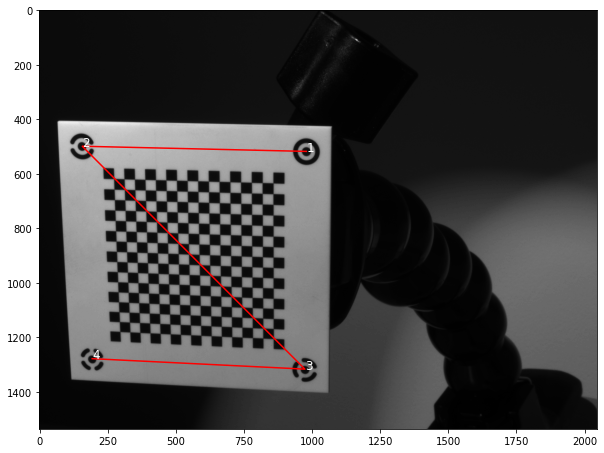

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(img.array_gs(torch.float), cmap='gray')
for idx, p_f in enumerate(ps_f): 
    plt.text(p_f[0], p_f[1], str(idx+1), color='w', fontsize=12)
plt.plot(ps_f[:,0], ps_f[:,1], 'r')

# Build

In [8]:
build_notebook()

<IPython.core.display.Javascript object>

Converted fiducial_detect.ipynb.
